# Problem

With over 50,000 publications and research papers on the coronavirus family available, it has become increasingly challenging for medical practitioners to search effectively and derive meaningful insights.

**How can this problem be addressed?**
- Can we match keywords from user queries with those in the abstracts?
- Would simple keyword matching capture the user's intent, such as distinguishing between terms like "origin" and "discovery"?Should we consider the - --
- context and relationships between words instead?

### Building a Search Engine with Word Embeddings

Let's explore the idea of creating a search engine that leverages word embeddings to improve search relevance and context understanding. **Given the query, we should fetch the top documents that are matching to the query**

In [1]:
!pip install -q langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 37.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
!gdown 18M7lJHV6Y4pJTsFzDw8_mf2_cQMuFcxE


Downloading...
From (original): https://drive.google.com/uc?id=18M7lJHV6Y4pJTsFzDw8_mf2_cQMuFcxE
From (redirected): https://drive.google.com/uc?id=18M7lJHV6Y4pJTsFzDw8_mf2_cQMuFcxE&confirm=t&uuid=a7a2a6c8-3883-4b7c-8444-aab5b533e1d4
To: /content/metadata.csv
100% 1.65G/1.65G [00:19<00:00, 86.5MB/s]


In [5]:
import numpy as np
import pandas as pd


import spacy
import string
import warnings

from pprint import pprint
from IPython.utils import io
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
from langdetect import DetectorFactory, detect
from IPython.core.display import HTML, display
from IPython.display import Image
from spacy.lang.en.stop_words import STOP_WORDS

warnings.filterwarnings('ignore')
tqdm.pandas()

In [11]:
data = pd.read_csv("metadata.csv").sample(150000)
data.reset_index(inplace=True, drop=True)
print(data.columns)
data.head(3)

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url', 's2_id'],
      dtype='object')


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,46fe2sc3,NaN,WHO,Living with Pompe disease in the UK: Character...,10.1016/j.ymgme.2021.11.145,NaN,NaN,unk,"Pompe disease is a rare, progressive, multisys...",2022,"Hughes, D.; Odedra, K.; Bashorum, L.; Muir, A....",Molecular Genetics and Metabolism,NaN,#covidwho-1677221,NaN,NaN,NaN,https://doi.org/10.1016/j.ymgme.2021.11.145,246607170.0
1,ihj0sni2,NaN,Medline,Psychometric properties of the Spanish version...,10.1080/07481187.2021.1899340,NaN,33755532,unk,The Coronavirus Disease 2019 (COVID-19) pandem...,2021-03-23,"Huarcaya-Victoria, Jeff; Elera-Fitzcarrald, Cl...",Death studies,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.1080/07481187.2021.1899340;...,232339456.0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          150000 non-null  object 
 1   sha               53032 non-null   object 
 2   source_x          150000 non-null  object 
 3   title             149926 non-null  object 
 4   doi               93299 non-null   object 
 5   pmcid             55402 non-null   object 
 6   pubmed_id         70719 non-null   object 
 7   license           150000 non-null  object 
 8   abstract          116479 non-null  object 
 9   publish_time      149753 non-null  object 
 10  authors           146480 non-null  object 
 11  journal           137617 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  68541 non-null   object 
 14  arxiv_id          2025 non-null    object 
 15  pdf_json_files    53032 non-null   object 
 16  pmc_json_files    45

In [13]:
df_data = pd.DataFrame(columns=['paper_id', 'title','abstract', 'doi'])
df_data['paper_id'] = data.sha
df_data['title'] = data.title
df_data['abstract'] = data.abstract
df_data['doi'] = data.doi

df_data.head()

,paper_id,title,abstract,doi
0,NaN,Living with Pompe disease in the UK: Character...,"Pompe disease is a rare, progressive, multisys...",10.1016/j.ymgme.2021.11.145
1,NaN,Psychometric properties of the Spanish version...,The Coronavirus Disease 2019 (COVID-19) pandem...,10.1080/07481187.2021.1899340
2,NaN,Rapid response to COVID-19 outbreak in Norther...,NaN,NaN
3,NaN,France: An unpopular government facing an unpr...,COVID-19 emerged as a new crisis on top of sev...,10.4324/9781003120254-9
4,daf177bb1a73a9e8c509e49b87af84c4f81bba1b,Prognostic factors for COVID-19 pneumonia prog...,Background Approximately 15-20% of COVID-19 pa...,10.1101/2020.03.28.20045989


In [14]:
df_data.isna().sum()

,0
paper_id,96968
title,74
abstract,33521
doi,56701


In [15]:
df_data.drop_duplicates(['abstract'], inplace=True)
df_data.dropna(inplace=True)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44251 entries, 4 to 149999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   paper_id  44251 non-null  object
 1   title     44251 non-null  object
 2   abstract  44251 non-null  object
 3   doi       44251 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB


In [16]:
# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# loop through each text
for ii in tqdm(range(0,len(df_data))):
    text = df_data.iloc[ii]['abstract'].split(" ")

    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))

        except Exception as e:
            lang = "unknown"
            pass
    languages.append(lang)

  0%|          | 0/44251 [00:00<?, ?it/s]

In [17]:
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)

print("Total: {}\n".format(len(languages)))
print(languages_dict)

Total: 44251

{'ca': 1, 'fr': 82, 'de': 90, 'da': 1, 'es': 83, 'pt': 7, 'fi': 1, 'it': 3, 'unknown': 1, 'nl': 17, 'no': 1, 'en': 43964}


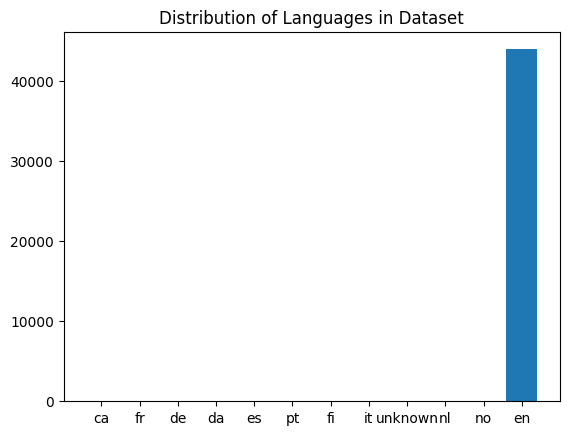

In [18]:
from matplotlib import pyplot as plt
df_data['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [19]:
df_data['language'] = languages
df_data = df_data[df_data['language'] == 'en']
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43964 entries, 4 to 149999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   paper_id  43964 non-null  object
 1   title     43964 non-null  object
 2   abstract  43964 non-null  object
 3   doi       43964 non-null  object
 4   language  43964 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


In [20]:
df_data = df_data.drop(['language'], axis = 1)
df_data.head()

,paper_id,title,abstract,doi
4,daf177bb1a73a9e8c509e49b87af84c4f81bba1b,Prognostic factors for COVID-19 pneumonia prog...,Background Approximately 15-20% of COVID-19 pa...,10.1101/2020.03.28.20045989
10,4476a1e5f239e37b046f773f604e4a5b2b543fe5; 7f46...,The impact of COVID-19 on patients with OCD: A...,BACKGROUND: Since the onset of the COVID-19 pa...,10.1016/j.jpsychires.2022.01.065
13,dfd68d886061dd68895338cdabf97b7e36ab7056,Effect of environmental enrichment and group s...,The grower-finisher stage accounts for 64% of ...,10.1038/s41598-021-95880-0
21,a57269680d29ff5497ff58217e62b7b6ba477af8,A rare cause of sudden unexpected death syndro...,BACKGROUND: Autopsies regularly aim to clarify...,10.1186/s12872-021-01977-9
24,0eed136e14229ae82e152619f027e6e709943e12,Role of the Uteroplacental Renin–Angiotensin S...,Placental development and function implicate i...,10.3390/biomedicines9101332


In [21]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure',
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.',
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [22]:
def pre_processor(sentence):
    mytokens = sentence.split(' ')
    mytokens = [word.lower() for word in mytokens if word not in stopwords and word not in punctuations]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

df_data["processed_abstract"] = df_data["abstract"].progress_apply(pre_processor)
df_data.head()

  0%|          | 0/43964 [00:00<?, ?it/s]

,paper_id,title,abstract,doi,processed_abstract
4,daf177bb1a73a9e8c509e49b87af84c4f81bba1b,Prognostic factors for COVID-19 pneumonia prog...,Background Approximately 15-20% of COVID-19 pa...,10.1101/2020.03.28.20045989,background approximately 15-20% covid-19 patie...
10,4476a1e5f239e37b046f773f604e4a5b2b543fe5; 7f46...,The impact of COVID-19 on patients with OCD: A...,BACKGROUND: Since the onset of the COVID-19 pa...,10.1016/j.jpsychires.2022.01.065,"background: since onset covid-19 pandemic, con..."
13,dfd68d886061dd68895338cdabf97b7e36ab7056,Effect of environmental enrichment and group s...,The grower-finisher stage accounts for 64% of ...,10.1038/s41598-021-95880-0,the grower-finisher stage accounts 64% total o...
21,a57269680d29ff5497ff58217e62b7b6ba477af8,A rare cause of sudden unexpected death syndro...,BACKGROUND: Autopsies regularly aim to clarify...,10.1186/s12872-021-01977-9,background: autopsies regularly aim clarify ca...
24,0eed136e14229ae82e152619f027e6e709943e12,Role of the Uteroplacental Renin–Angiotensin S...,Placental development and function implicate i...,10.3390/biomedicines9101332,placental development function implicate impor...


In [23]:
df_data["processed_abstract"].head()

,processed_abstract
4,background approximately 15-20% covid-19 patie...
10,"background: since onset covid-19 pandemic, con..."
13,the grower-finisher stage accounts 64% total o...
21,background: autopsies regularly aim clarify ca...
24,placental development function implicate impor...


In [25]:
df_data.loc[10,"processed_abstract"]

'background: since onset covid-19 pandemic, concerns psychological effects people preexisting psychiatric disorders raised, particularly obsessive-compulsive disorder (ocd). nevertheless, longitudinal studies performed, longstanding follow-up clinical sample needed. in study, aim investigate influence covid-19 pandemic symptom changes sample brazilian ocd patients one-year period. methods: thirty ocd outpatients seen specialized ocd clinic rio de janeiro evaluated baseline year (during pandemic). sociodemographic clinical variables collected questionnaire aimed quantifying number stressful events related covid-19 pandemic. comparisons time points (pre vs. covid-19) subgroups (patients vs worsening symptoms) carried out. results: as group, ocd patients treated sris overall stabilization symptoms follow-up period, regardless number stressful experiences related coronavirus (median baseline ybocs remained 22.0 follow-up). in addition, individually analyzed, reported increase symptoms desc

In [33]:
pprint(df_data["processed_abstract"].head(5).to_dict())

{4: 'background approximately 15-20% covid-19 patients develop severe '
    'pneumonia, 10 die properly managed. methods 125 covid-19 patients '
    'enrolled study classified mild (93 cases) severe (32 cases) groups, '
    "basing 3 7-days clinical outcomes. patients' gender, age, comorbid "
    'underlying diseases, epidemiological history, clinical manifestations, '
    'laboratory tests admission collected subsequently analyzed single-factor '
    'multivariate logistic regression methods. finally, evaluate prognostic '
    'values receiver operating characteristic curve (roc) analysis. results '
    'seventeen factors admission differed significantly mild severe groups. '
    'next, factors, including comorbid underlying diseases, increased '
    'respiratory rate (>24/min), elevated c-reactive protein (crp '
    '>10mg/liter), lactate dehydrogenase (ldh >250u/liter), found '
    'independently associated later disease development. prognostic value '
    'analysis roc indicated in

In [34]:
abstracts = df_data['processed_abstract'].values


nlp = spacy.load('en_core_web_sm', disable=["tagger", "ner"])
nlp.add_pipe('sentencizer')

def tokenize_sentences(sentence):
    sentence_corpus = []
    doc = nlp(sentence)
    sentences = [sent.text.strip() for sent in doc.sents]
    for sent in sentences:
        processed_sent_list = sent.split(" ")
        sentence_corpus.append(processed_sent_list)
    return sentence_corpus

df_data['tokenized_abstract'] = df_data['processed_abstract'].progress_apply(lambda x: tokenize_sentences(x))

corpus_data = df_data['tokenized_abstract'].to_list()
word2vec_corpus = [item for items in corpus_data for item in items]

  0%|          | 0/43964 [00:00<?, ?it/s]

In [37]:
model = Word2Vec(word2vec_corpus, min_count=3, vector_size= 100, workers=4, window =5, sg = 1, negative=5)

In [38]:
model.save("word2vec_model.model")

In [39]:
a = [0.0]*100
df_data["centroid"] = [a]*df_data.shape[0]

for index, row in df_data.iterrows():
    abstract = row['processed_abstract']
    total_sim = 0
    words = abstract.split(" ")
    centroid = np.array([0.0]*100)
    for word in words:
        try:
            b = model.wv[word]
        except:
            continue
        centroid = np.add(centroid, b)

    df_data.at[index,'centroid'] = centroid.tolist()

In [46]:
def rank_docs(model, query, df_covid, num) :

    cosine_list = []

    a = []
    query = query.split(" ")
    for q in query:
        try:
            a.append(model.wv[q])
        except:
            continue

    for index, row in df_covid.iterrows():
        centroid = row['centroid']
        total_sim = 0
        for a_i in a:
            cos_sim = np.dot(a_i, centroid)/(np.linalg.norm(a_i)*np.linalg.norm(centroid))
            total_sim += cos_sim
        cosine_list.append((row['title'],row['processed_abstract'], total_sim))


    cosine_list.sort(key=lambda x:x[2], reverse=True)

    papers_list = []
    for item in cosine_list[:num]:
        papers_list.append((item[0], item[1], item[2]))
    return papers_list

In [41]:
df_data.to_csv("processed_data.csv", index=False)

In [47]:
def query(query, top_matches=5):
    model_to_use = model
    df_covid_to_use = df_data
    return rank_docs(model_to_use, query, df_covid_to_use, top_matches)

In [48]:
query('origin of corona virus')

[('Is the discovery of the novel human betacoronavirus 2c EMC/2012 (HCoV-EMC) the beginning of another SARS-like pandemic?',
  'fouchier reported isolation genome sequencing novel coronavirus tentatively named “human betacoronavirus 2c emc/2012 (hcov-emc)” saudi patient presenting pneumonia renal failure june 2012. genome sequencing showed virus belongs group c species genus betacoronavirus phylogenetically related bat coronaviruses hku4 hku5 previously found lesser bamboo bat japanese pipistrelle bat hong kong respectively. another patient qatar similar clinical presentation positive rt-pcr test reported september 2012. we compare contrast clinical presentation, laboratory diagnosis management infection novel coronavirus sars coronavirus despite paucity published information former. since 70% emerging infectious pathogens came animals, emergence novel virus represent instance interspecies jumping betacoronavirus animals human similar group a coronavirus oc43 possibly bovine source 189

In [49]:
query('covid treatment')

[('Potential therapeutic approach of intravenous immunoglobulin against COVID-19',
  'since outbreak novel coronavirus disease (covid-19), therapeutic management options reduce burden covid-19 disease investigation. ivig therapy effective treatment immunodeficient patients patients inflammatory autoimmune conditions. the therapeutic effect ivig covid-19 patients investigated. but, results controversial studies reported benefit ivig therapy. more clinical trials effect ivig therapy covid-19 patients performed establish certain conclusion ivig effectiveness.',
  1.280379393109169),
 ('A prospective clinical study of an Ayurveda regimen in COVID 19 patients',
  'introduction the ancient indian system medicine, ayurveda treatment symptom complexes variety disease. one combination ayurvedic medications potential use covid 19 infection, prospective study conducted formulation add on, covid positive patients dedicated covid hospital. objective to evaluate additional benefit ayurvedic regime c

In [50]:
query('covid symptoms')

[('Manifestations and risk factors of post COVID syndrome among COVID-19 patients presented with minimal symptoms – A study from Kerala, India',
  'background: covid 19 associated development post covid syndrome usually manifested fatigue, anxiety, joint pain, headache, chest pain, dementia, depression, dyspnea. documented evidence post covid syndrome patients asymptomatic mild infections, especially india less. methodology: a community based prospective cohort study conducted 154 patients admitted cfltcs coastal thiruvananthapuram, kerala may-august 2020. they enrolled time admission cfltcs followed months discharge. the discharged patients followed regular intervals weeks months telephonic interview structured proforma. results: out 154 patients followed up, 57 (37%) men 97 (63%) women. the mean (sd) age study participants 31.49 (18.4) years. at symptom present 120 (78.0%) patients time admission. cough (29, 18.8%), fever (26, 16.8%), headache (25, 16.2%), rhinitis (23,14.9%) sore th